# U-Net on Graphene Images
This is a modification to a U-Net on the Oxford-IIIT Pet Dataset. Original code is located at https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb

Mount Google Drive and define path to dataset. There are two paths: one to the dataset (dataset_dir) and another to the folder which you put `utils.py' in (project_dir).

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.1 MB/s eta 0:00:00


In [4]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Define hyper-parameters

In [5]:
import os
import sys

epochs = 100 # no. of training epochs
batch_size = 5 
default_learning_rate = 0.0001

# define U-Net input image size
default_input_size = (256,256,3)

# define weight of positive errors
pos_weight = 150
 
# start training your model. Set to 0 if you want to train from scratch
initial_epoch = epochs
threshold = 0.884


# directory of the project, folder which you put utils.py in
project_dir = os.path.abspath("/content/gdrive/MyDrive/project")
# path to the dataset, should contain 3 subfolders: train2019, val2019 and annotations
dataset_dir = os.path.abspath("/content/gdrive/MyDrive/project/dataset")

# model paths to save or load the models
model_path = f"/content/gdrive/MyDrive/project/models/unet/Unet_pw{pos_weight}.h5"
# model_path1 = "/content/gdrive/MyDrive/project/models/unet/Good_model7.h5"

color_model_path = f"/content/gdrive/MyDrive/project/models/color/color_pw{pos_weight}.h5"
sys.path.append(project_dir)  # To find local version of the library: utils
# import utils

Import the libraries for use

In [6]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from PIL import Image
import json

from google.colab.patches import cv2_imshow

# from random import shuffle

Define augmenter: 

In [7]:
# define augmenter
# first crop images at a random position
# then randomly apply 0 to 4 of the methods: horizontally flip, vertically flip, rotate and shift
seq_train = iaa.Sequential([
            iaa.SomeOf((0, 4),[
                iaa.Fliplr(), # horizontally flip
                iaa.Flipud(), # vertically flip
                iaa.Affine(rotate=(0,359)), # rotate
                iaa.Affine(translate_percent={"x": (-0.1, 0.1),"y": (-0.1, 0.1)}), # shift
                # More as you want ...
    ])
])


# Dataset loading class

In [8]:
#@title Functions for printing the images conveniently

def print_images(images, labels, params=[]):
  n = len(images)
  fig, ax = plt.subplots(1,n,figsize=(10, 20*n))
  if len(params) < n:
    params += [{} for i in range(n - len(params))]
  [axi.set_axis_off() for axi in ax.ravel()]
  for i in range(n):
    ax[i].imshow(images[i], **params[i])
    ax[i].set_title(labels[i],fontsize=14)
  plt.show()


def print_img_msk(image, masks):
  img = cv2.resize(image, (256, 256))
  msk_DL = cv2.resize(masks[:,:,0] * 255, default_input_size[:2])
  msk_ML = cv2.resize(masks[:,:,1] * 128, default_input_size[:2])
  print_images([img, msk_DL + msk_ML], 
               ['Image', 'Ground Truth'],
               [{}, {'cmap': 'gray'}])
  # cv2_imshow(cv2.resize(image, (256, 256)))
  # cv2_imshow(cv2.resize(masks[:,:,0] * 255, (256, 256)) + cv2.resize(masks[:,:,1] * 128, (256, 256)))
  

In [9]:
#@title The Class holding the dataset
# This is very specific to the dataset.
# So, you need to change it if you have a different one.

label_to_ind = {"BL": 0, "ML": 1}
mask_threshold = 254

def get_pic_filenames(dataset_type: str, pic_type: str):
  # dataset_type is either 'train' or 'val'
  # pic_type is either 'pure' or 'scraped'
  path = os.path.join(dataset_dir, dataset_type, pic_type, 'raw')
  possible_extensions = ('.jpg', '.png')
  pictures = np.array(
      list(filter(lambda file: file.endswith(possible_extensions), os.listdir(path))))
  return pictures

class Dataset:
  def __init__(self, dataset_type: str):
    self.images = []
    self.masks = []

    self.load_pure_images(dataset_type)
    self.load_scraped_images(dataset_type)
    
    self.num_images = len(self.images)
    self.image_ids = np.arange(self.num_images)
    
    # print(self.masks.shape)
    # for i in self.image_ids:
      # print_img_msk(self.images[i], self.masks[i])

  def load_pure_images(self, dataset_type):
    pic_filenames = get_pic_filenames(dataset_type, "pure")
    path_pure_raw = os.path.join(dataset_dir, dataset_type, "pure", "raw")
    path_pure_mask = os.path.join(dataset_dir, dataset_type, "pure", "mask")

    self.images += [np.array(Image.open(os.path.join(path_pure_raw, pic))) for pic in pic_filenames]
    # print(pic_filenames)
    for pic in pic_filenames:
      with open(os.path.join(path_pure_mask, pic[:-4] + ".json"), 'r') as file:
        d = json.load(file)
        mask = np.zeros((d['imageHeight'], d['imageWidth'], len(label_to_ind)), np.uint8)
        for shape in d['shapes']:
          if shape['label'] not in label_to_ind.keys():
            raise RuntimeError('Unexpected label')
          polygon = np.array(shape['points'], np.int32)
          curmask = np.copy(mask[:,:,label_to_ind[shape['label']]])
          cv2.fillPoly(curmask, [polygon], 1)
          mask[:,:,label_to_ind[shape['label']]] = curmask
        self.masks.append(mask)
      
  def load_scraped_images(self, dataset_type):
    path_raw = os.path.join(dataset_dir, dataset_type, "scraped", "raw")
    path_ML = os.path.join(dataset_dir, dataset_type, "scraped", "mask", "ML")
    path_BL = os.path.join(dataset_dir, dataset_type, "scraped", "mask", "BL")
    scraped_filenames = get_pic_filenames(dataset_type, "scraped")

    self.images += [np.array(Image.open(os.path.join(path_raw, filename))) for filename in scraped_filenames]
    # print(self.images[-1].shape)
    
    for filename in scraped_filenames:
      mask = np.zeros((182, 182, len(label_to_ind)), np.uint8)
      mask[:,:,label_to_ind['ML']] = np.array(Image.open(os.path.join(path_ML, filename)))[:,:,0] >= mask_threshold
      mask[:,:,label_to_ind['BL']] = np.array(Image.open(os.path.join(path_BL, filename)))[:,:,0] >= mask_threshold
      self.masks.append(mask)


  def load_image(self, index):
    return self.images[index]

  def prepare(self):
    pass
    # TODO: probably white balance and stuff

  def load_mask(self, index):
    # where n_classes is 2 in case of mono\bilayer graphene
    # CLASS ID_S:
    #   1 - bilayer graphene
    #   2 - monolayer graphene
    return self.masks[index], np.array([1, 2])

def get_train_val_datasets():
  return Dataset("train"), Dataset("val")

In [10]:
dataset_train, dataset_val = get_train_val_datasets()


np.mean(r)=0.49492779360264827
np.mean(g)=0.5936901387774045
np.mean(b)=0.586568118371609
total_mean=0.5583953502505539
0.5583953502505539


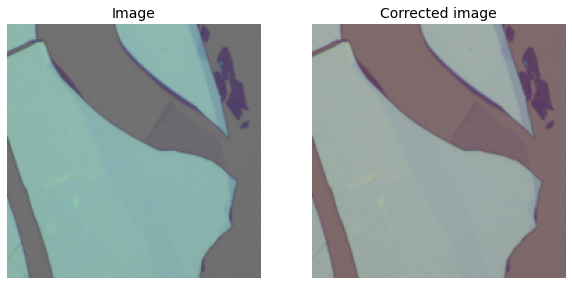

In [11]:
#@title Image "Correction" (not used, because isn't usefull) { run: "auto"}
index = 21 #@param {type:"slider", min:0, max:57, step:1}

img = dataset_train.load_image(index) / 255

r, g, b = cv2.split(img)
rm, gm, bm = np.mean(r), np.mean(g), np.mean(b)

total_mean = np.sum(r + g + b) / (3 * r.size)
# total = rm + gm + bm
# kr, kg, kb = total / (3 * rm), total / (3 * gm), total / (3 * bm)

print(f'{np.mean(r)=}\n{np.mean(g)=}\n{np.mean(b)=}\n{total_mean=}')



corrected_img = np.copy(img)
corrected_img[:, :, 0] *= total_mean / rm
corrected_img[:, :, 1] *= total_mean / gm 
corrected_img[:, :, 2] *= total_mean / bm

print(total_mean)
print_images([img, corrected_img],
             ['Image', 'Corrected image'])

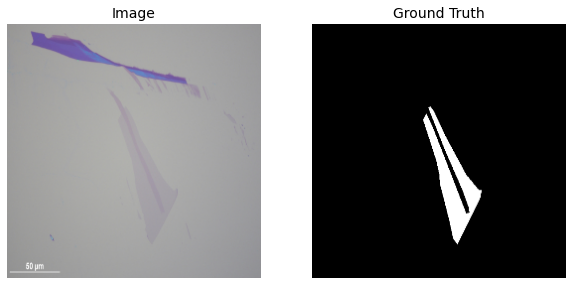

In [12]:
#@title `dataset_train.load_image{mask}(index)` { run: "auto"}
index = 0 #@param {type:"slider", min:0, max:57, step:1}

print_img_msk(dataset_train.load_image(index), dataset_train.load_mask(index)[0])

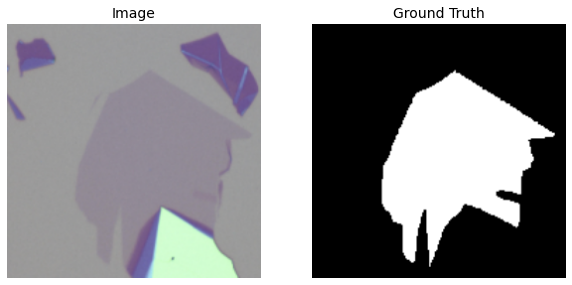

In [13]:
#@title `dataset_val.load_image{mask}(index)` { run: "auto"}
index = 7 #@param {type:"slider", min:0, max:7, step:1}

print_img_msk(dataset_val.load_image(index), dataset_val.load_mask(index)[0])

# Generator function

In [14]:
#@title Generator function

def image_generator(dataset,seq=None, batch_size = 5, image_size = (256,256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataset.image_ids, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    if seq: # apply augmentation
      # make stochastic augmenter deterministic (similar to drawing random samples from a distribution)
        seq_det = seq.to_deterministic()

    for f in batch:

        #preprocess the raw images 
        raw = dataset.load_image(f)

        raw = np.clip(cv2.resize(raw, dsize=image_size,interpolation=cv2.INTER_CUBIC),0, 255)

        #get the mask
        mask = np.clip(np.sum(dataset.load_mask(f)[0],axis=-1,keepdims=True),a_min=0,a_max=1)
        mask = cv2.resize(mask.astype(np.float32), dsize=image_size, interpolation=cv2.INTER_CUBIC)

        # pre-process the mask 
        mask[mask != 0 ] = 1
        batch_x.append(raw)
        batch_y.append(mask)

    # pre-process a batch of images and masks 
    batch_x = np.array(batch_x)/255. # normalize raw images
    batch_y = np.expand_dims(np.array(batch_y),3)# add color channel to the black-and-white masks

    if seq:
        # augment images and masks
        batch_x = np.array(seq_det.augment_images(batch_x))
        batch_y = np.array(seq_det.augment_images(batch_y))

    yield (batch_x, batch_y)

In [15]:
# build a Dataset object for images
dataset_train, dataset_val = get_train_val_datasets()

# build generators for training and testing
train_generator = image_generator(dataset_train,seq=seq_train, batch_size = batch_size,image_size=default_input_size[:2])

test_generator  = image_generator(dataset_val,seq=None, batch_size = batch_size,image_size=default_input_size[:2])

Test the generators by plotting the images

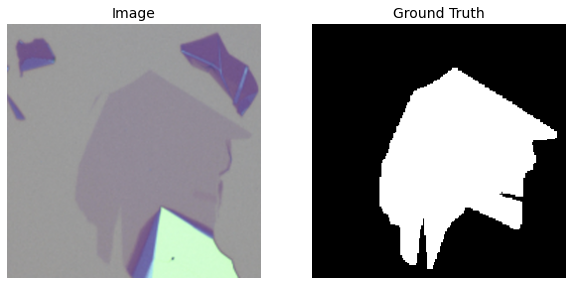

In [16]:
x, y= next(test_generator) # x is the raw images, y is the ground truth masks

img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis = -1)

print_images([img, msk], ['Image', 'Ground Truth'])

In [17]:
#@title Functions for loading

mask_type_to_int = {
    "ML" : 2,
    "BL" : 1
}

# layer_type: ML or BL
def load_mask(dataset, mask_ind, layer_type : str, mask_size=default_input_size[:2]):
  # Returns: a mask of size (mask_size[0], mask_size[1]) of type float32
  # Values inside: 0. and 1.
  mask = np.clip(np.sum(dataset.load_mask(mask_ind)[0]
                        [:,:,[a for a in range(len(dataset_train.load_mask(i)[1])) if dataset_train.load_mask(i)[1][a] == mask_type_to_int[layer_type]]],
                        axis=-1,keepdims=True),
                 a_min=0,a_max=1)
  mask = cv2.resize(mask.astype(np.float32), dsize=mask_size, interpolation=cv2.INTER_CUBIC)
  mask[mask != 0] = 1
  return mask


def load_raw(dataset, img_ind, img_size=default_input_size[:2]):
  # Returns: a raw image resized to size (img_size[0], img_size[1], 3) of float32
  # Values: normalized to [0, 1)
  return cv2.resize(dataset.load_image(img_ind), # Original raw images
                         dsize=img_size,
                         interpolation=cv2.INTER_CUBIC)/255

# Metrics

> CAUTION: they don't take the mean over all pictures. They process all predictions united.

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [18]:
# miou_metric = tf.keras.metrics.MeanIoU(num_classes=2)
def mean_iou(y_true, y_pred):
  # miou_metric.reset_state()
  # miou_metric.update_state(y_true, y_pred > threshold)
  yt0 = y_true[:,:,:,0]
  yp0 = K.cast(y_pred[:,:,:,0] > threshold, 'float32')
  inter = tf.math.count_nonzero(tf.math.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
  union = tf.math.count_nonzero(tf.add(yt0, yp0))
  iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
  return iou

def precision(y_true, y_pred_mask):
  y_pred_mask = K.cast(y_pred_mask > threshold, 'float32')
  tp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 1)))
  fp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(y_pred_mask, 1)))
  return tp / (tp + fp) if tp + fp != 0 else tf.constant(0, 'float64')

def recall(y_true, y_pred_mask):
  y_pred_mask = K.cast(y_pred_mask > threshold, 'float32')
  tp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 1)))
  fn = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 0)))
  return tp / (tp + fn) if tp + fn != 0 else tf.constant(0, 'float64')
  

t = np.array([[1, 1], [0, 0]]).astype(np.float32)
p = np.array([[1, 1], [1, 0]])
print(mean_iou(t[None,:,:,None], p[None,:,:,None]), precision(t, p), recall(t, p))

tf.Tensor(0.6666667, shape=(), dtype=float32) tf.Tensor(0.6666666666666666, shape=(), dtype=float64) tf.Tensor(1.0, shape=(), dtype=float64)


# UNet model

Model for identifying interesting regions.

## Weighted binary crossentropy loss 
Assume we have $N$ samples in total, $y_{true}$ is a ground truth segmentation mask, $y_{pred}$ is the CNN-predicted segmentation mask, the binary crossentropy is defined as:
$$L_{binary\_ce} = -\frac{1}{N}\sum_{1}^{N}y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
And weighted binary crossentropy is defined as:
$$L_{w\_binary\_ce} = -\frac{1}{N}\sum_{1}^{N} w * y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
Here, $w$ represents the weight for positive errors. Weighted loss here is used to handle class imbalance in the dataset.

In [19]:
def create_weighted_binary_crossentropy(pos_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
        
        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * pos_weight + (1. - y_true)
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

## UNet model function

In [20]:
def unet_attached(sz = default_input_size):
  x = Input(sz) 
  inputs = x
  
  #down sampling 
  Num_of_filters = 8 
  layers = [] 
  
  for i in range(6):
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    Num_of_filters = Num_of_filters * 2

    
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1 
  x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
  x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(5):
    ff2 = ff2//2
    Num_of_filters = Num_of_filters // 2 
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
  x = Conv2D(Num_of_filters, 3, activation='relu', padding='same') (x)
  

  ########################################################
  ###### Attached layers to the original UNet model ######
  ########################################################
  x = Conv2D(256, 5,activation='linear', padding='same')(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  x = Conv2D(128, 5,activation='linear', padding='same')(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  x = Conv2D(64, 5,activation='linear', padding='same')(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  x = Conv2D(32, 5,activation='linear', padding='same')(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  x = Conv2D(16, 5,activation='linear', padding='same')(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  ########################################################
  ########################################################
  
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])

  # Optimizer for the model
  opt = keras.optimizers.Adam(learning_rate = default_learning_rate) # use Adam as optimizer

  # Compile the model
  model.compile(optimizer = opt, loss = create_weighted_binary_crossentropy(pos_weight), metrics = [mean_iou, precision, recall])
  
  return model


## Custom callbacks

In [21]:
def build_callbacks():
  checkpointer = ModelCheckpoint(filepath = model_path, verbose = 0, save_best_only = True, save_weights_only = False)
  callbacks = [checkpointer, PlotLearning()]
  return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

  def on_train_begin(self, logs = {}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    self.logs = []

  def on_epoch_end(self, epoch, logs = {}):
    self.logs.append(logs)
    self.x.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('mean_iou'))
    self.val_acc.append(logs.get('val_mean_iou'))
    
    if enable_wandb:
      wandb.log({'train/loss': logs.get('loss'),
                'train/mean_iou': logs.get('mean_iou'),
                'train/recall': logs.get('recall'),
                'val/loss': logs.get('val_loss'),
                'val/mean_iou': logs.get('val_mean_iou'),
                'val/recall': logs.get('val_recall'),
                })
    
    print('epoch =',epoch,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'),'recall=',logs.get('recall'),'val_recall=',logs.get('val_recall'))
    if epoch % 10 != 0 and epoch != epochs - 1:
      return

    if enable_wandb:
      table = wandb.Table(columns=['raw', 'prediction', 'pred_with_threshold', 'true_mask', 'iou', 'recall', 'precision'])
    fig, ax = plt.subplots(3,4,figsize=(10, 8))
    [axi.set_axis_off() for axi in ax.ravel()]
    for i in range(3):
      #choose a test image and preprocess
      # path = np.random.choice(dataset_val.image_ids)
      test_index_to_print = i
      raw = cv2.resize(dataset_val.load_image(test_index_to_print),
                      dsize=default_input_size[:2],
                      interpolation=cv2.INTER_CUBIC)/255.
      # get ground truth mask
      mask = np.clip(np.sum(dataset_val.load_mask(test_index_to_print)[0],axis=-1,keepdims=True),a_min=0,a_max=1)
      mask = cv2.resize(mask.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)

      # pre-process the mask 
      mask[mask != 0 ] = 1
      # mask = np.tile(mask[:,:,np.newaxis], (1,1,3))

      #predict the mask 
      pred = model_attached.predict(np.expand_dims(raw, 0))
      
      # predicted mask post-processing 
      pred = np.clip(pred.squeeze(), 0, 1)

      pred_mask = np.array(pred) > threshold
      # pred_mask = exponen(pred_mask)

      
      if enable_wandb:
        table.add_data(wandb.Image(raw*255), wandb.Image(pred*255), wandb.Image(pred_mask * 255), wandb.Image(mask*255), 
                        mean_iou(mask[None,:,:,None], pred_mask[None,:,:,None]), recall(mask, pred_mask), precision(mask, pred_mask))
    
      #show the mask and the segmented image 
      ax[i][0].imshow(raw)
      ax[i][0].set_title('Image',fontsize=14)
      ax[i][1].imshow(mask,cmap='gray', vmin=0., vmax=1.)
      ax[i][1].set_title('Ground Truth',fontsize=14)
      ax[i][2].imshow(pred,cmap='gray', vmin=0., vmax=1.)
      ax[i][2].set_title('Prediction',fontsize=14)
      ax[i][3].imshow(pred_mask,cmap='gray', vmin=0., vmax=1.)
      ax[i][3].set_title('Post-processed prediction',fontsize=14)

    if enable_wandb:
      wandb.log({'interesting_region_table':table}, commit=False)
    plt.show()

## Build the model and train

In [22]:
model_path

'/content/gdrive/MyDrive/project/models/unet/Unet_pw150.h5'

In [23]:
enable_wandb = True
force_new_model = False

train_steps = (dataset_train.num_images + batch_size - 1) // batch_size
test_steps = (dataset_val.num_images + batch_size - 1) // batch_size


get_custom_objects().update({"weighted_binary_crossentropy":create_weighted_binary_crossentropy(pos_weight),
                              "mean_iou":mean_iou,
                              "recall":recall,
                              "precision":precision})

# code checking if ckpt exists
if os.path.isfile(model_path) and not force_new_model:
  model_attached = load_model(model_path)
else:
  initial_epoch = 0
  model_attached = unet_attached()

if epochs != initial_epoch:
  # print model summary 
  # model_attached.summary()
  if enable_wandb:
    wandb.init(project='UNET_test',
              name='test_run',
              config={
                  'epochs': epochs - initial_epoch,
                  'batch_size': batch_size,
                  'learning_rate': default_learning_rate,
                  'positive_weight': pos_weight,
              })

  model_attached.fit(train_generator, 
            epochs = epochs,
            initial_epoch = initial_epoch,
            steps_per_epoch = train_steps,
            validation_data = test_generator,
            validation_steps = test_steps,
            callbacks = build_callbacks(),
            verbose = 0)
  
  if enable_wandb:
    wandb.finish()

#Plot raw images + ground truth masks + detection masks for attached UNet model

1/1 [==============================] - 11s 11s/step


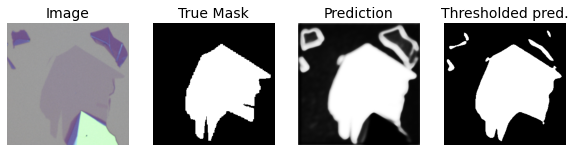

1/1 [==============================] - 0s 23ms/step


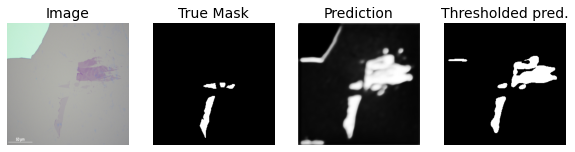

1/1 [==============================] - 0s 23ms/step


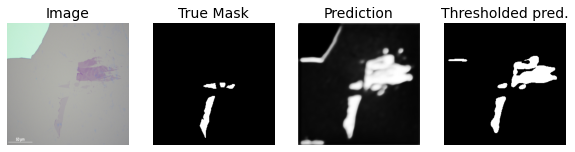

1/1 [==============================] - 0s 24ms/step


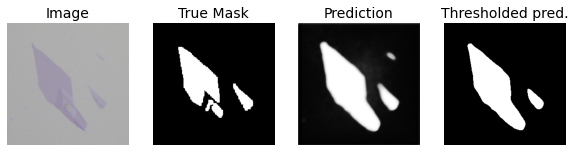

1/1 [==============================] - 0s 31ms/step


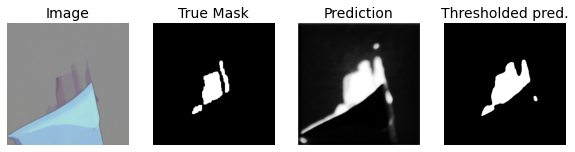

0.103997802734375
0.116068691630166


In [24]:
for i in range(batch_size):  
  img = x[i]
  msk = y[i].squeeze()
  pred = model_attached.predict(np.expand_dims(img, 0)).squeeze()
  pred_mask = (pred >= threshold).astype(np.float32) # pred >= threshold
  print_images([img, msk, pred, pred_mask], ['Image', 'True Mask', 'Prediction', 'Thresholded pred.'], [{}] + [{'cmap':'gray'}] * 3)

total_msk_graphene = np.sum(y)
grd_graphene_to_whole_image = total_msk_graphene/(default_input_size[0] * default_input_size[1] * batch_size)
grd_graphene_to_bg = total_msk_graphene/(default_input_size[0] * default_input_size[1] * batch_size - total_msk_graphene)
print(grd_graphene_to_whole_image)
print(grd_graphene_to_bg)

# Evaluation Metrics

In [25]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def false_alarm_m(y_true, y_pred):
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_alarm = false_positives / (false_positives + true_negatives)
    return false_alarm 

recall_m(msk,pred_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9844173>

In [26]:
def compute_recall_precision(dataset, threshold, model_name, model_name2 = None, sz = default_input_size[:2]):    
    recall = 0
    precision = 0
    false_alarm = 0
       
    for im_id in dataset.image_ids:

        #get the mask
        mask = np.clip(np.sum(dataset.load_mask(im_id)[0], axis = -1, keepdims = True), a_min = 0, a_max = 1)
        mask = cv2.resize(mask.astype(np.float32), dsize = sz, interpolation = cv2.INTER_CUBIC)

        #preprocess the raw images 
        raw = cv2.resize(dataset.load_image(im_id), dsize = sz, interpolation = cv2.INTER_CUBIC)
        pred = model_name.predict(np.expand_dims(raw/255., 0)).squeeze() # raw image (256,256,3), after expansion: (1, 256, 256, 3)

        if model_name2 != None: 
          pred = pred[:,:,None]*(raw/255.)
          pred = model_name2.predict(np.expand_dims(pred, 0)).squeeze() #pred(=raw image * pred mask ) (256,256,3), after expansion: (1, 256, 256, 3)

        # Threshold it to 0 or 1
        pred_mask = (pred >= threshold).astype(np.float32)
        recall += recall_m(mask,pred_mask)
        precision += precision_m(mask,pred_mask)
        false_alarm += false_alarm_m(mask,pred_mask)

    recall /= len(dataset.image_ids)
    precision /= len(dataset.image_ids)
    false_alarm /= len(dataset.image_ids)
    return (recall, precision, false_alarm)

In [27]:
rec_val_attached_value, prec_val_attached_values, false_ala_val_attached_value = compute_recall_precision(dataset_val, threshold, model_attached)
print(rec_val_attached_value, prec_val_attached_values, false_ala_val_attached_value )

1/1 [==============================] - 0s 26ms/step
tf.Tensor(0.8668453, shape=(), dtype=float32) tf.Tensor(0.31556073, shape=(), dtype=float32) tf.Tensor(0.05991686, shape=(), dtype=float32)


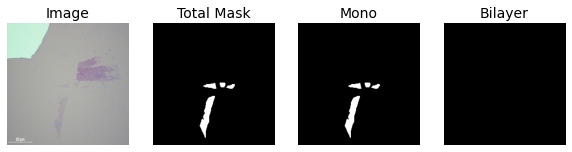

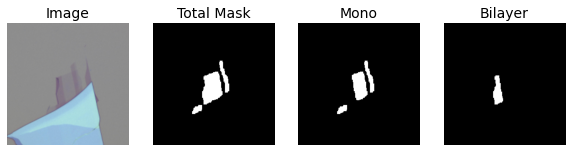

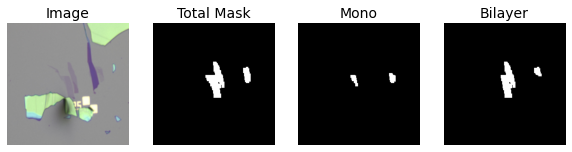

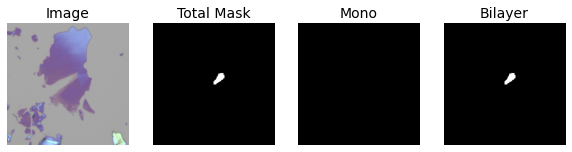

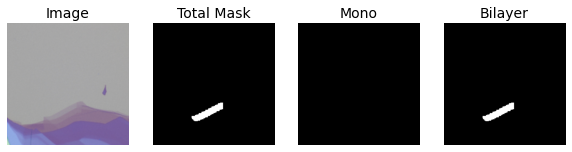

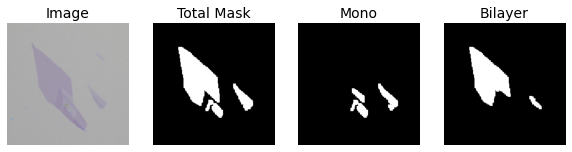

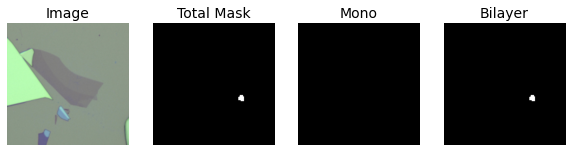

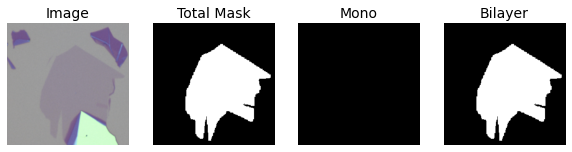

In [28]:
for j in range(dataset_val.num_images):
  raw = load_raw(dataset_val, j)
  # Ground truth monolayer
  mmask = load_mask(dataset_val, j, 'ML')
  # Ground truth bilayer
  bmask = load_mask(dataset_val, j, 'BL')
  # Ground truth both layers
  mask = np.clip(mmask + bmask, 0, 1)

  print_images([raw, mask, mmask, bmask], ['Image', 'Total Mask', 'Mono', 'Bilayer'], [{}] + [{'cmap':'gray'}] * 3)


# Color training dataset

In [29]:
## Step 1. Create empty lists to store pixel values
R0 = [] # create 3 lists to store background pixel values
G0 = []
B0 = []
R1 = [] # create 3 lists to store monolayer pixel values
G1 = []
B1 = []
R2 = [] # create 3 lists to store bilayer pixel values
G2 = []
B2 = []

## Step 2. Load total ground truth RGB pixel intensities multiplied by UNet masks
for i in range(dataset_train.num_images): 
    
    raw = cv2.resize(dataset_train.load_image(i), # Original raw images
                         dsize=default_input_size[:2],
                         interpolation=cv2.INTER_CUBIC)/255
    pred_mask = model_attached.predict(np.expand_dims(raw, 0)).squeeze() # predict masks from UNet
    graphene_pred = pred_mask[:,:,None] * raw
    graphene_pred = graphene_pred*(1 + np.sign(pred_mask[:,:,None] - threshold))/2

#Ground truth monolayer
    mmask = load_mask(dataset_train, i, "ML")
    graphene1 = mmask[:,:,None] * graphene_pred # Unet predicted monolayer mask

# Ground truth bilayer
    bmask = load_mask(dataset_train, i, "BL")
    graphene2 = bmask[:,:,None] * graphene_pred # Unet predicted bilayer mask

# Combine the monolayer and bilayer ground truths                    
    graphene = np.append(graphene1, graphene2, axis = 0)
    r, g, b = cv2.split(graphene)
    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = graphene.reshape((np.shape(graphene)[0]*np.shape(graphene)[1], 3))

## Step 3. Plot the RGB distribution of total ground truth pixel intensities multiplied by UNet masks
    pix_c=[] 
    R=[]
    G=[]
    B=[]
    r=r.flatten()
    g=g.flatten()
    b=b.flatten()
    for j in range(len(r)):
      if r[j]+g[j]+b[j] != 0:
        R.append(r[j])
        G.append(g[j])
        B.append(b[j])
        pix_c.append(pixel_colors[j])
    R=np.array(R)
    G=np.array(G)
    B=np.array(B)
    # axis.scatter(R, G, B, facecolors =pix_c, marker=".")
    # axis.set_xlabel("Red")
    # axis.set_ylabel("Green")
    # axis.set_zlabel("Blue")
    # plt.show()

## Step 4. Prepare and store the background, monolayer and bilayer RGB pixel values separately  
    # Monolayer
    r1, g1, b1 = cv2.split(graphene1) # monolayer RGB pixel intensities
    r1=r1.flatten()
    g1=g1.flatten()
    b1=b1.flatten()  
    for j in range(len(r1)):
      if r1[j]+g1[j]+b1[j] != 0:
        R1.append(r1[j])
        G1.append(g1[j])
        B1.append(b1[j])        
    
    # Bilayer
    r2, g2, b2 = cv2.split(graphene2) # graphene1 is monolayer   
    r2=r2.flatten()
    g2=g2.flatten()
    b2=b2.flatten()  
    for j in range(len(r1)):
      if r2[j]+g2[j]+b2[j] != 0:
        R2.append(r2[j])
        G2.append(g2[j])
        B2.append(b2[j])

    # for background
    mask = np.clip(np.sum(dataset_train.load_mask(i)[0],axis=-1,keepdims=True),a_min=0,a_max=1)
    mask = cv2.resize(mask.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
    # pre-process the mask 
    mask[mask != 0 ] = 1
    background = (1 - mask)[:,:,None] * graphene_pred
    r0, g0, b0 = cv2.split(background) # graphene1 is monolayer   
    r0=r0.flatten()
    g0=g0.flatten()
    b0=b0.flatten()  
    for j in range(len(r0)):
      if r0[j]+g0[j]+b0[j] != 0:
        R0.append(r0[j])
        G0.append(g0[j])
        B0.append(b0[j])

## Step 5. Convert the RGB list to array 
R1=np.array(R1)
G1=np.array(G1)
B1=np.array(B1)
result1 = np.ones(len(R1)) # monolayer

R2=np.array(R2)
G2=np.array(G2)
B2=np.array(B2)
result2 = 2*np.ones(len(R2)) # bilayer

R0=np.array(R0)
G0=np.array(G0)
B0=np.array(B0)
result0 = np.zeros(len(R0)) # background

## Step 6. Combine the RGB values of monolayer, bilayer and background for SVM input dataset
graphene_R_train = np.append(R0, R1)
graphene_R_train = np.append(graphene_R_train, R2)
graphene_G_train = np.append(G0, G1)
graphene_G_train = np.append(graphene_G_train,G2)
graphene_B_train = np.append(B0, B1)
graphene_B_train = np.append(graphene_B_train,B2)
result_train = np.append(result0, result1)
result_train = np.append(result_train, result2)

1/1 [==============================] - 0s 33ms/step


# Color testing dataset

In [30]:
## similart process to SVM training dataset but here is for testing dataset
R0 = []
G0 = []
B0 = []
R1 = []
G1 = []
B1 = []
R2 = []
G2 = []
B2 = []
# print the ground truth monolayer distribution
for i in range(dataset_val.num_images): 
    
    raw = cv2.resize(dataset_val.load_image(i),
                         dsize=default_input_size[:2],
                         interpolation=cv2.INTER_CUBIC)/255
    pred_mask = model_attached.predict(np.expand_dims(raw, 0)).squeeze()
    graphene_pred = pred_mask[:,:,None] * raw
    graphene_pred = graphene_pred*(1 + np.sign(pred_mask[:,:,None]- threshold))/2

#Ground truth monolayer
    mmask = load_mask(dataset_val, i, "ML")
    graphene1 = mmask[:,:,None] * graphene_pred # Unet predicted monolayer mask

# Ground truth bilayer
    bmask = load_mask(dataset_val, i, "BL")
    graphene2 = bmask[:,:,None] * graphene_pred # Unet predicted bilayer mask
                        
    graphene = np.append(graphene1, graphene2,axis = 0)
    r, g, b = cv2.split(graphene)
    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")

    pixel_colors = graphene.reshape((np.shape(graphene)[0]*np.shape(graphene)[1], 3))

    pix_c=[]
    R=[]
    G=[]
    B=[]
    r=r.flatten()
    g=g.flatten()
    b=b.flatten()
    for j in range(len(r)):
      if r[j]+g[j]+b[j] != 0:
        R.append(r[j])
        G.append(g[j])
        B.append(b[j])
        pix_c.append(pixel_colors[j])
    R=np.array(R)
    G=np.array(G)
    B=np.array(B)
    # axis.scatter(R, G, B, facecolors =pix_c, marker=".")
    # axis.set_xlabel("Red")
    # axis.set_ylabel("Green")
    # axis.set_zlabel("Blue")
    # plt.show()

    # for monolayer
    r1, g1, b1 = cv2.split(graphene1) # graphene1 is monolayer
    r1=r1.flatten()
    g1=g1.flatten()
    b1=b1.flatten()  
    for j in range(len(r1)):
      if r1[j]+g1[j]+b1[j] != 0:
        R1.append(r1[j])
        G1.append(g1[j])
        B1.append(b1[j])        
    
 
    # for bilayer
    r2, g2, b2 = cv2.split(graphene2) # graphene1 is monolayer   
    r2=r2.flatten()
    g2=g2.flatten()
    b2=b2.flatten()  
    for j in range(len(r1)):
      if r2[j]+g2[j]+b2[j] != 0:
        R2.append(r2[j])
        G2.append(g2[j])
        B2.append(b2[j])

    # for background
    mask = np.clip(np.sum(dataset_val.load_mask(i)[0],axis=-1,keepdims=True),a_min=0,a_max=1)
    mask = cv2.resize(mask.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
    # pre-process the mask 
    mask[mask != 0 ] = 1
    background = (1 - mask)[:,:,None] * graphene_pred
    r0, g0, b0 = cv2.split(background) # graphene1 is monolayer   
    r0=r0.flatten()
    g0=g0.flatten()
    b0=b0.flatten()  
    for j in range(len(r0)):
      if r0[j]+g0[j]+b0[j] != 0:
        R0.append(r0[j])
        G0.append(g0[j])
        B0.append(b0[j])
        pix_c.append(pixel_colors[j])

R1=np.array(R1)
G1=np.array(G1)
B1=np.array(B1)
result1 = np.ones(len(R1))

R2=np.array(R2)
G2=np.array(G2)
B2=np.array(B2)
result2 = 2*np.ones(len(R2))

R0=np.array(R0)
G0=np.array(G0)
B0=np.array(B0)
result0 = np.zeros(len(R0))

graphene_R_val = np.append(R0, R1)
graphene_R_val = np.append(graphene_R_val, R2)
graphene_G_val = np.append(G0, G1)
graphene_G_val = np.append(graphene_G_val,G2)
graphene_B_val = np.append(B0, B1)
graphene_B_val = np.append(graphene_B_val,B2)
result_val = np.append(result0, result1)
result_val = np.append(result_val, result2)

1/1 [==============================] - 0s 24ms/step


# Data Preparation

In [31]:
# Preparing for the training dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

X_Train = np.stack((graphene_R_train, graphene_G_train, graphene_B_train), axis = 0)
X_Train = X_Train.transpose()

X_Test = np.stack((graphene_R_val, graphene_G_val, graphene_B_val), axis = 0)
X_Test = X_Test.transpose()

Y_Train = result_train
Y_Test = result_val

In [32]:
# Dataset Normalization
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_Train, Y_Train, train_size=0.8)

In [34]:
print(x_train.shape)
print(x_val.shape)
print(X_Test.shape)

(173940, 3)
(43485, 3)
(58540, 3)


In [35]:
n_classes = 3

def data_loader(X, y, batch_size=64):
  while True:
    batch = np.random.choice(X.shape[0], batch_size)
    batch_x = X[batch]
    batch_y = y[batch]
    batch_y = np.eye(n_classes)[batch_y.astype(np.int32)]
    yield batch_x, batch_y


y_train_one_hot = np.eye(n_classes)[y_train.astype(np.int32)]
y_val_one_hot = np.eye(n_classes)[y_val.astype(np.int32)]
Y_Test_one_hot = np.eye(n_classes)[Y_Test.astype(np.int32)]

In [36]:
color_batch_size = 64
color_train_steps = x_train.shape[0] // color_batch_size
color_val_steps = x_val.shape[0] // color_batch_size
color_epochs = 30
color_initial_epoch = color_epochs
color_learning_rate = 0.0001

color_train_data_loader = data_loader(x_train, y_train, batch_size=color_batch_size)
color_val_data_loader = data_loader(x_val, y_val, batch_size=color_batch_size)
color_test_data_loader = data_loader(X_Test, Y_Test, batch_size=color_batch_size)



In [37]:
x, y = next(color_train_data_loader)
print(x.shape)

(64, 3)


# Color model

## Model build funciton

In [38]:
def build_color_model():

  x = tf.keras.layers.Input(3)
  inputs = x
  x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)
  x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(x)
  outputs = tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)(x)

  color_model = Model(inputs=[inputs], outputs=[outputs])

  color_model.summary()

  color_optimizer = tf.keras.optimizers.Adam(learning_rate=color_learning_rate)

  color_model.compile(optimizer=color_optimizer, loss=tf.keras.losses.CategoricalCrossentropy())
  return color_model


## Metrics


In [39]:
def one_hot_recall(y_true, y_pred):
  n_classes = y_true.shape[-1]
  pred_vals = tf.math.argmax(y_pred, axis=-1)
  result = []
  for i in range(n_classes):
    true_class_mask = tf.equal(y_true[:,i], tf.constant(1, 'float32'))
    true_vals = tf.cast(tf.equal(pred_vals[true_class_mask], i), 'int64')
    tp = tf.reduce_sum(true_vals)
    fn = tf.reduce_sum(tf.cast(true_class_mask, 'int64')) - tp # FN = T - TP
    # print(i, tp, fn)
    result.append((tp / (tp + fn) if tp + fn != 0 else tf.constant(0, 'float64')).numpy().item())
  return result

def one_hot_precision(y_true, y_pred):
  n_classes = y_true.shape[-1]
  pred_vals = tf.math.argmax(y_pred, axis=-1)
  result = []
  for i in range(n_classes):
    true_class_mask = tf.equal(y_true[:,i], tf.constant(1, 'float32'))
    true_vals = tf.cast(tf.equal(pred_vals[true_class_mask], i), 'int64')
    tp = tf.reduce_sum(true_vals)
    fp = tf.reduce_sum(tf.cast(tf.equal(pred_vals, i), 'int64')) - tp # FP = P - TP
    # print(i, tp, fp)
    result.append((tp / (tp + fp) if tp + fp != 0 else tf.constant(0, 'float64')).numpy().item())
  return result

In [40]:
y_true = tf.constant([[0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1]], 'float32')
y_pred = tf.constant([[1, 0, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0]], 'float32')

print(one_hot_recall(y_true, y_pred))
print(one_hot_precision(y_true, y_pred))

[0.0, 0.5, 0.3333333333333333]
[0.0, 0.3333333333333333, 1.0]


## Prediction functions

In [41]:
def color_predict(x):
  # x.shape: (None, 3)
  return np.argmax(color_model(x),axis=-1)

def get_segmentation(raw_img):
  pred_mask = model_attached.predict(np.expand_dims(raw_img, 0)).squeeze()
  interesting_region = pred_mask[:,:,None] * raw_img
  interesting_region = interesting_region*(1 + np.sign(pred_mask[:,:,None]- threshold))/2

  red = interesting_region[:,:,0]
  green = interesting_region[:,:,1]
  blue = interesting_region[:,:,2]
  mask = red + green + blue != 0
  to_predict = interesting_region[mask].reshape([-1, 3])
  to_predict = sc_X.transform(to_predict)
  preds = color_predict(to_predict)
  pos = 0
  for i in range(raw_img.shape[0]):
    for j in range(raw_img.shape[1]):
      if np.sum(red[i][j] + green[i][j] + blue[i][j]) == 0:
        interesting_region[i,j,:]=0
      else:
        y = preds[pos]
        pos += 1
        interesting_region[i,j,:]=0 
        if y==1:
          interesting_region[i,j,0]=255
        elif y==2:
          interesting_region[i,j,1]=255
        elif y==0:
          # graphene_pred[i,k,:]=128
          pass
  return interesting_region



## Custom Callbacks

In [42]:
def build_color_callbacks():
  checkpointer = ModelCheckpoint(filepath=color_model_path, verbose=0, save_best_only=True, save_weights_only=False)
  callbacks = [checkpointer, PlotColorLearning()]
  return callbacks

class PlotColorLearning(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    y_train_pred = color_model(x_train)
    recall_train = one_hot_recall(y_train_one_hot, y_train_pred) 
    precision_train = one_hot_precision(y_train_one_hot, y_train_pred)

    y_val_pred = color_model(x_val)
    recall_val = one_hot_recall(y_val_one_hot, y_val_pred)
    precision_val = one_hot_precision(y_val_one_hot, y_val_pred)

    print(f'{epoch=}, loss={logs.get("loss")}, val_loss={logs.get("val_loss")},\n'
    # f'precis_bg={logs.get("one_hot_precision")[0]}, precis_ml={logs.get("one_hot_precision")[1]}, precis_bl={logs.get("one_hot_precision")[2]}\n'
    f'recall_bg={recall_train[0]}, val_recall_bg={recall_val[0]}\n'
    f'recall_ml={recall_train[1]}, val_recall_ml={recall_val[1]}\n'
    f'recall_bl={recall_train[2]}, val_recall_bl={recall_val[2]}\n')

    if enable_wandb:
      wandb.log({'COLOR/train/recall/background': recall_train[0],
                 'COLOR/train/recall/monolayer':  recall_train[1],
                 'COLOR/train/recall/bilayer':    recall_train[2],
                 'COLOR/train/precision/background': precision_train[0],
                 'COLOR/train/precision/monolayer':  precision_train[1],
                 'COLOR/train/precision/bilayer':    precision_train[2],
                 'COLOR/train/loss': logs.get('loss'),

                 'COLOR/val/recall/background':   recall_val[0], 
                 'COLOR/val/recall/monolayer':    recall_val[1],
                 'COLOR/val/recall/bilayer':      recall_val[2],
                 'COLOR/val/precision/background':   precision_val[0], 
                 'COLOR/val/precision/monolayer':    precision_val[1],
                 'COLOR/val/precision/bilayer':      precision_val[2],
                 'COLOR/val/loss': logs.get('val_loss')
                 })
      
    if epoch % 5 == 0 or epoch == epochs - 1:
      if enable_wandb:
        table = wandb.Table(columns=['Original', 'Mono GT', 'Bi GT', 'Segm(R=ML,G=BL)'])
      fig, ax = plt.subplots(3,4,figsize=(10, 8))
      [axi.set_axis_off() for axi in ax.ravel()]
      for i in range(3):
        #choose a test image and preprocess
        # path = np.random.choice(dataset_val.image_ids)
        test_index_to_print = i
        raw = cv2.resize(dataset_val.load_image(test_index_to_print),
                        dsize=default_input_size[:2],
                        interpolation=cv2.INTER_CUBIC)/255.
        # get ground truth mask
        mono_mask = load_mask(dataset_val, test_index_to_print, 'ML')
        bi_mask = load_mask(dataset_val, test_index_to_print, 'BL')
        segmentation = get_segmentation(raw)


        # print_images([raw, mono_mask, bi_mask, segmentation], ['Original', 'Mono GT', 'Bi GT', 'Segmentation'], [{}, {'cmap':'gray'}, {'cmap':'gray'}, {}])
        
        ax[i][0].imshow(raw)
        ax[i][0].set_title('Original',fontsize=14)
        ax[i][1].imshow(mono_mask,cmap='gray', vmin=0., vmax=1.)
        ax[i][1].set_title('Mono GT',fontsize=14)
        ax[i][2].imshow(bi_mask,cmap='gray', vmin=0., vmax=1.)
        ax[i][2].set_title('Bi GT',fontsize=14)
        ax[i][3].imshow(segmentation, vmin=0., vmax=1.)
        ax[i][3].set_title('(Green=ML, Red=BL)',fontsize=14)

        if enable_wandb==True:
          table.add_data(wandb.Image(raw*255), wandb.Image(mono_mask*255), wandb.Image(bi_mask*255), wandb.Image(segmentation))
      

      if enable_wandb:
        wandb.log({'segmentation_table':table}, commit=False)
      plt.show()




In [43]:
from sklearn.metrics import classification_report, confusion_matrix

def log_report_table(y_true, y_pred, class_names, metrics, table_name):
  report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
  table = wandb.Table(['class', *contents])
  for class_name in class_names:
    table.add_data(class_name, *[report[class_name][metric] for metric in contents])
  wandb.log({table_name:table})


## Build model and train

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________


wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin


epoch=0, loss=0.8925078511238098, val_loss=0.7879679799079895,
recall_bg=0.900163982963992, val_recall_bg=0.8982532950243991
recall_ml=0.3419162568916704, val_recall_ml=0.339564961787184
recall_bl=0.47429190998839665, val_recall_bl=0.4772083046043055

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 91ms/step


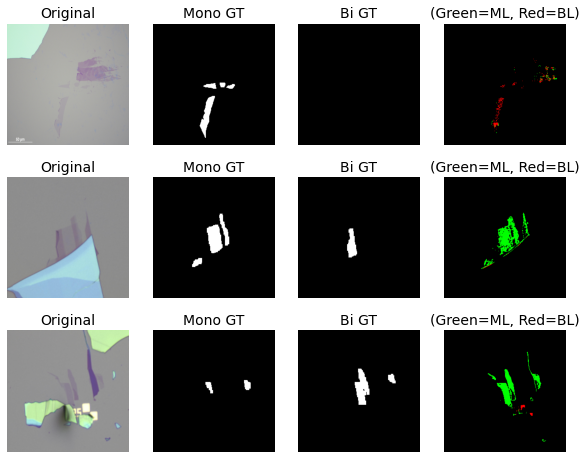

epoch=1, loss=0.7326436042785645, val_loss=0.6921306252479553,
recall_bg=0.8408454232810258, val_recall_bg=0.8399689880056551
recall_ml=0.5281180151989271, val_recall_ml=0.5259259259259259
recall_bl=0.7227558920317285, val_recall_bl=0.7284915345131387

epoch=2, loss=0.6825000643730164, val_loss=0.6645380258560181,
recall_bg=0.8228072972418976, val_recall_bg=0.8194919505632325
recall_ml=0.6239904634182685, val_recall_ml=0.6232804232804233
recall_bl=0.7334081527838542, val_recall_bl=0.7415153604535356

epoch=3, loss=0.659820020198822, val_loss=0.6501300930976868,
recall_bg=0.837952945999499, val_recall_bg=0.8353627947279609
recall_ml=0.6019967218000298, val_recall_ml=0.5995296884185773
recall_bl=0.731696182305834, val_recall_bl=0.7376848234122424

epoch=4, loss=0.6487658619880676, val_loss=0.6378196477890015,
recall_bg=0.8230578267702189, val_recall_bg=0.8201304327997446
recall_ml=0.6431232305170616, val_recall_ml=0.6453850676072899
recall_bl=0.7324760799680432, val_recall_bl=0.740442810

1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 40ms/step


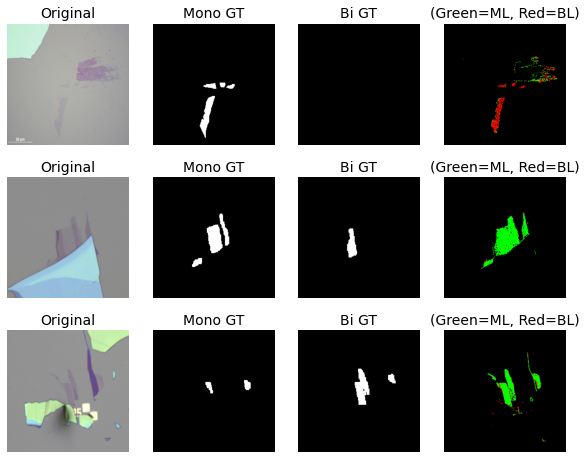

epoch=6, loss=0.6407763361930847, val_loss=0.6331160664558411,
recall_bg=0.8290022092149315, val_recall_bg=0.8261960140466093
recall_ml=0.6706601102667262, val_recall_ml=0.6699588477366255
recall_bl=0.7253809134313595, val_recall_bl=0.7323986822952578

epoch=7, loss=0.6353726983070374, val_loss=0.6252061128616333,
recall_bg=0.8332953743138907, val_recall_bg=0.8308022073243033
recall_ml=0.6811503501713605, val_recall_ml=0.679835390946502
recall_bl=0.7195982575944913, val_recall_bl=0.7274955948824026

epoch=8, loss=0.6268724799156189, val_loss=0.619793713092804,
recall_bg=0.831234199558157, val_recall_bg=0.8285219136224746
recall_ml=0.668514379377142, val_recall_ml=0.6650205761316872
recall_bl=0.7289760514352019, val_recall_bl=0.7351566689649889

epoch=9, loss=0.6220338344573975, val_loss=0.6150086522102356,
recall_bg=0.836165076183752, val_recall_bg=0.8331737127742053
recall_ml=0.681269557443004, val_recall_ml=0.6783068783068783
recall_bl=0.7154324627646421, val_recall_bl=0.723052171914

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


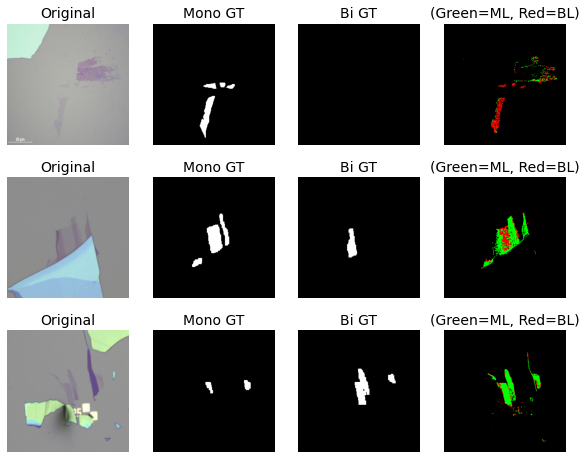

epoch=11, loss=0.6166204810142517, val_loss=0.6190187931060791,
recall_bg=0.8164643450930376, val_recall_bg=0.8137912163086606
recall_ml=0.7038295336015497, val_recall_ml=0.7037037037037037
recall_bl=0.732628255121645, val_recall_bl=0.7412089174902321

epoch=12, loss=0.6131161451339722, val_loss=0.6112746596336365,
recall_bg=0.8300840412690459, val_recall_bg=0.8273817667715602
recall_ml=0.6845179555952913, val_recall_ml=0.6851263962375074
recall_bl=0.7306690000190219, val_recall_bl=0.7384509308205011

epoch=13, loss=0.6110897660255432, val_loss=0.6046072244644165,
recall_bg=0.8378846197645022, val_recall_bg=0.8345874948693391
recall_ml=0.6950976009536581, val_recall_ml=0.691710758377425
recall_bl=0.7134351638736185, val_recall_bl=0.7209836819122041

epoch=14, loss=0.6064189672470093, val_loss=0.5970382690429688,
recall_bg=0.8389436764069511, val_recall_bg=0.8356364299721805
recall_ml=0.6996870809119357, val_recall_ml=0.69782480893592
recall_bl=0.714157995853227, val_recall_bl=0.7209836

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


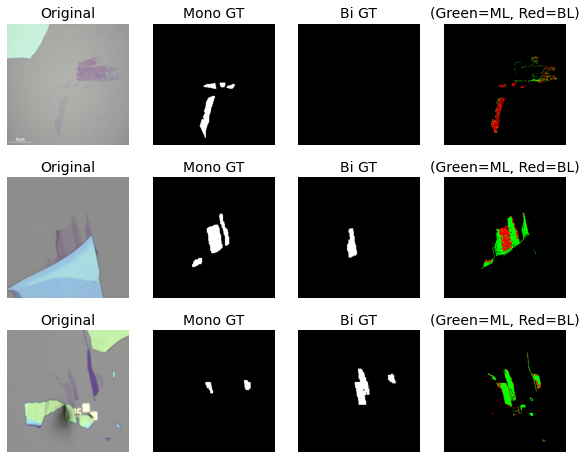

epoch=16, loss=0.601066529750824, val_loss=0.5944005846977234,
recall_bg=0.8447855694991687, val_recall_bg=0.8423404934555571
recall_ml=0.701803009983609, val_recall_ml=0.7013521457965902
recall_bl=0.7072720701527458, val_recall_bl=0.7140121044970504

epoch=17, loss=0.5981689095497131, val_loss=0.5975440144538879,
recall_bg=0.8364953196529027, val_recall_bg=0.8332649245222785
recall_ml=0.7151840262255997, val_recall_ml=0.7159318048206937
recall_bl=0.7129976603070134, val_recall_bl=0.719911131540642

epoch=18, loss=0.5951218605041504, val_loss=0.5926489233970642,
recall_bg=0.837110255767873, val_recall_bg=0.8338578008847539
recall_ml=0.7117270153479363, val_recall_ml=0.7112286890064667
recall_bl=0.7161172509558502, val_recall_bl=0.7225925074695473

epoch=19, loss=0.5960601568222046, val_loss=0.5905967354774475,
recall_bg=0.8369849910037124, val_recall_bg=0.8339490126328271
recall_ml=0.7142005662345403, val_recall_ml=0.7146384479717813
recall_bl=0.7159840976964487, val_recall_bl=0.722592

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 28ms/step


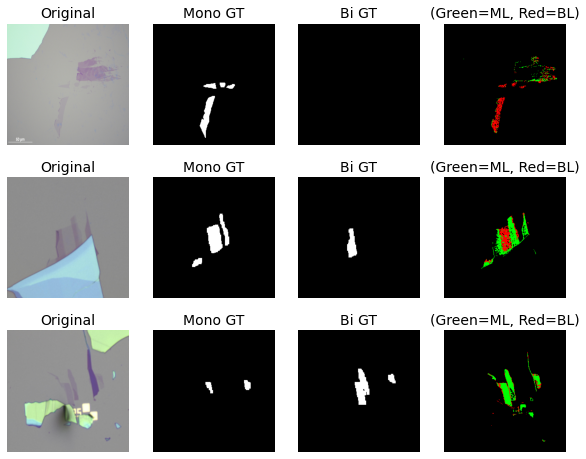

epoch=21, loss=0.5866844058036804, val_loss=0.5807403326034546,
recall_bg=0.8429635365659234, val_recall_bg=0.839558535139326
recall_ml=0.7144389807778274, val_recall_ml=0.7159318048206937
recall_bl=0.7109432957333891, val_recall_bl=0.7156975407952195

epoch=22, loss=0.5853637456893921, val_loss=0.5849083662033081,
recall_bg=0.84041269045938, val_recall_bg=0.8376430884297897
recall_ml=0.7117270153479363, val_recall_ml=0.7127572016460906
recall_bl=0.7177721557512697, val_recall_bl=0.7222860645062438

epoch=23, loss=0.5822671055793762, val_loss=0.5834115147590637,
recall_bg=0.8388981255836199, val_recall_bg=0.8362749122086924
recall_ml=0.7175681716584712, val_recall_ml=0.7200470311581423
recall_bl=0.717201498925263, val_recall_bl=0.7225158967287214

epoch=24, loss=0.5827784538269043, val_loss=0.5744174718856812,
recall_bg=0.8419158676293074, val_recall_bg=0.8401514115018014
recall_ml=0.712084637162867, val_recall_ml=0.7142857142857143
recall_bl=0.7189515131916836, val_recall_bl=0.7225158

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


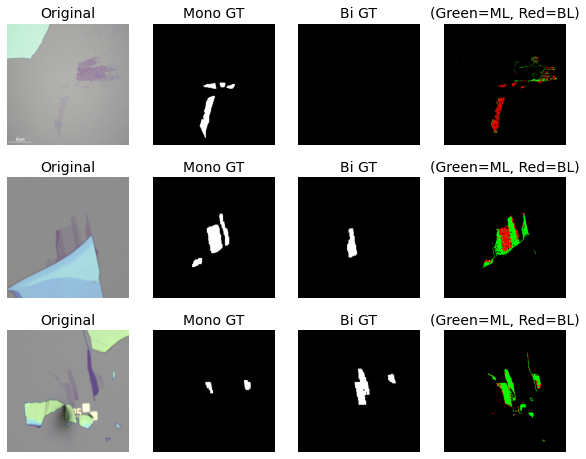

epoch=26, loss=0.5785942077636719, val_loss=0.5821752548217773,
recall_bg=0.839524449404423, val_recall_bg=0.8363661239567657
recall_ml=0.7272239606616003, val_recall_ml=0.7282774838330394
recall_bl=0.7106199235319853, val_recall_bl=0.7156209300543936

epoch=27, loss=0.5760452151298523, val_loss=0.5752243399620056,
recall_bg=0.8553305851003257, val_recall_bg=0.8521913622474575
recall_ml=0.6985844136492326, val_recall_ml=0.6993533215755438
recall_bl=0.7138726674402237, val_recall_bl=0.7179958630199954

epoch=28, loss=0.5780770778656006, val_loss=0.5787845253944397,
recall_bg=0.8450588744391555, val_recall_bg=0.8419756464632645
recall_ml=0.7136939353300551, val_recall_ml=0.7147560258671369
recall_bl=0.7155846379182439, val_recall_bl=0.7207538496897264

epoch=29, loss=0.5765848755836487, val_loss=0.5791533589363098,
recall_bg=0.8375543762953516, val_recall_bg=0.8355452182241072
recall_ml=0.7211741916256892, val_recall_ml=0.7238095238095238
recall_bl=0.7235928553765384, val_recall_bl=0.726

COLOR/train/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
COLOR/train/precision/background,▁▆▇▇███▇▇▇███▇██▇██████████▇██
COLOR/train/precision/bilayer,▁▁▂▂▂▃▄▅▄▅▅▄▅▆▆▅▇▇▇▇▇▇▇▇▇████▇
COLOR/train/precision/monolayer,▁▆▄▇▄▄▅▅▅▅▄▄▆▅▅▆▅▄▅▅▅▅▅▅▆▅▄█▆▅
COLOR/train/recall/background,█▃▂▃▂▁▂▃▂▃▂▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃
COLOR/train/recall/bilayer,▁████████▇███▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇█
COLOR/train/recall/monolayer,▁▄▆▆▆▇▇▇▇▇▇█▇▇▇▇███████████▇██
COLOR/val/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
COLOR/val/precision/background,▁▆▇▇████▇▇███▇██▇██████████▇██
COLOR/val/precision/bilayer,▁▁▁▂▂▃▄▅▄▅▅▄▅▆▆▆▇▇▇▇▇▇▇▇▇████▇
COLOR/val/precision/monolayer,▁▇▄▇▄▄▄▄▅▅▄▃▆▅▅▆▅▄▅▄▅▅▅▅▆▅▃█▆▅


In [44]:
enable_wandb = True
color_force_new_model = False

get_custom_objects().update({'one_hot_precision':one_hot_precision,
                             'one_hot_recall':one_hot_recall})

if os.path.isfile(color_model_path) and not color_force_new_model:
  color_model = load_model(color_model_path)
else:
  color_model = build_color_model()
  color_initial_epoch = 0

if color_epochs != color_initial_epoch:
  if enable_wandb:
    wandb.init(project='ColNET_test',
              name='test_run',
              config={
                  'epochs': color_epochs - color_initial_epoch,
                  'batch_size': color_batch_size,
                  'learning_rate': color_learning_rate,
              })

  color_model.fit(color_train_data_loader,
                  epochs=color_epochs,
                  initial_epoch=color_initial_epoch,
                  steps_per_epoch = color_train_steps,
                  validation_data=color_val_data_loader,
                  validation_steps=color_val_steps,
                  callbacks=build_color_callbacks(),
                  verbose=0
                  )
  

  if enable_wandb:
    
    y_pred_train = color_predict(x_train)
    y_pred_val = color_predict(x_val)
    y_pred_test = color_predict(X_Test)
    class_names = ['Background', 'Monolayer', 'Bilayer']
    wandb.log({'val/confusion_matrix': wandb.plot.confusion_matrix(probs=None, 
                                                                  y_true=Y_Test,
                                                                  preds=y_pred_test,
                                                                  class_names=class_names)})
    wandb.log({'train/confusion_matrix': wandb.plot.confusion_matrix(probs=None, 
                                                                    y_true=y_train,
                                                                    preds=y_pred_train,
                                                                    class_names=class_names)})

    contents = ['precision', 'recall', 'f1-score', 'support'] # should be a subset of {'precision', 'recall', 'f1-score', 'support'}
    log_report_table(y_train, y_pred_train, class_names=class_names, metrics=contents, table_name='train/report')
    log_report_table(Y_Test, y_pred_test, class_names=class_names, metrics=contents, table_name='val/report')
    wandb.finish()

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_train = color_predict(x_train)
y_pred_val = color_predict(x_val)
y_pred_test = color_predict(X_Test)

print("==== TRAIN ====")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("==== VAL ====")
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("==== TEST ====")
print(confusion_matrix(Y_Test, y_pred_test))
print(classification_report(Y_Test, y_pred_test))

==== TRAIN ====
[[73549  6546  7719]
 [ 5910 24199  3446]
 [10171  4360 38040]]
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     87814
         1.0       0.69      0.72      0.70     33555
         2.0       0.77      0.72      0.75     52571

    accuracy                           0.78    173940
   macro avg       0.76      0.76      0.76    173940
weighted avg       0.78      0.78      0.78    173940

==== VAL ====
[[18321  1672  1934]
 [ 1505  6156   844]
 [ 2489  1077  9487]]
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     21927
         1.0       0.69      0.72      0.71      8505
         2.0       0.77      0.73      0.75     13053

    accuracy                           0.78     43485
   macro avg       0.76      0.76      0.76     43485
weighted avg       0.78      0.78      0.78     43485

==== TEST ====
[[17535  1681  3584]
 [ 1443  2718  1547]
 [ 3384  1862 24786]]
 

# Plot the Coloring results

In [46]:
def log_segmentation_pics(dataset, indexes=None, enable_wandb=False, table_name=None):
  if indexes == None:
    indexes = np.arange(dataset.num_images)
  if enable_wandb==True:        
    table = wandb.Table(columns=['Original', 'Mono GT', 'Bi GT', 'Segmentation'])

  
  for i in indexes:
    raw = cv2.resize(dataset.load_image(i),
                    dsize=default_input_size[:2],
                    interpolation=cv2.INTER_CUBIC)/255
    mono_mask = load_mask(dataset, i, 'ML')
    bi_mask = load_mask(dataset, i, 'BL')
    segmentation = get_segmentation(raw)

    print_images([raw, mono_mask, bi_mask, segmentation], ['Original', 'Mono GT', 'Bi GT', 'Segmentation'], [{}, {'cmap':'gray'}, {'cmap':'gray'}, {}])
    if enable_wandb==True:
      table.add_data(wandb.Image(raw*255), wandb.Image(mono_mask*255), wandb.Image(bi_mask*255), wandb.Image(segmentation*255))
  
  if enable_wandb==True:
    wandb.log({table_name:table}, commit=False)


1/1 [==============================] - 0s 29ms/step


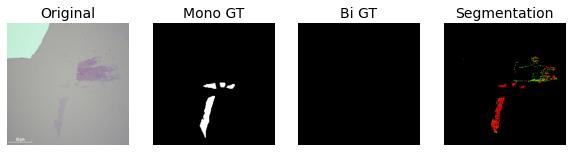

1/1 [==============================] - 0s 28ms/step


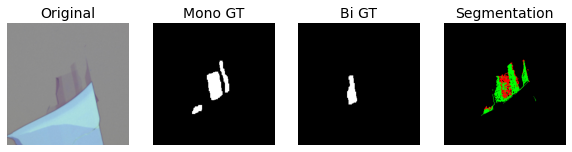

1/1 [==============================] - 0s 27ms/step


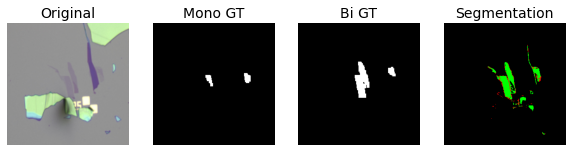

1/1 [==============================] - 0s 27ms/step


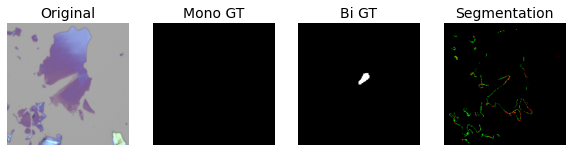

1/1 [==============================] - 0s 85ms/step


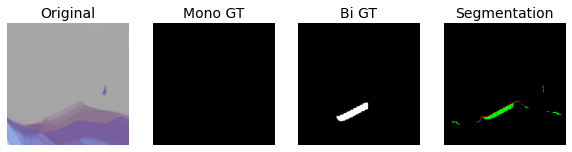

1/1 [==============================] - 0s 88ms/step


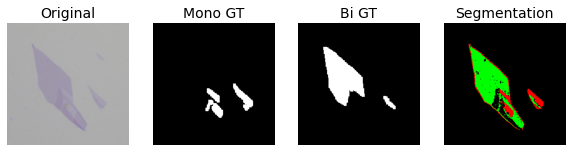

1/1 [==============================] - 0s 26ms/step


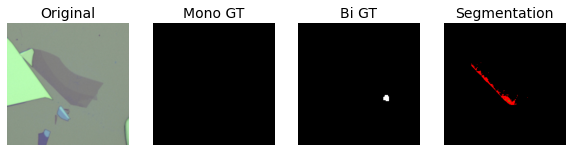

1/1 [==============================] - 0s 26ms/step


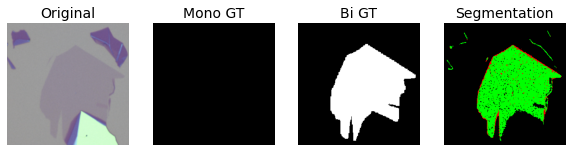

In [47]:
log_segmentation_pics(dataset_val)

1/1 [==============================] - 0s 27ms/step


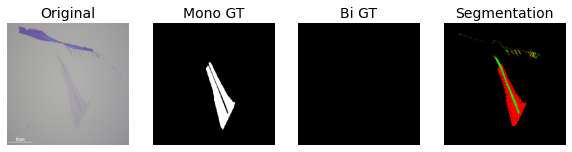

1/1 [==============================] - 0s 26ms/step


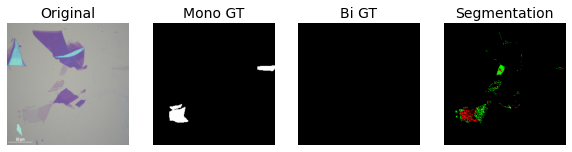

1/1 [==============================] - 0s 29ms/step


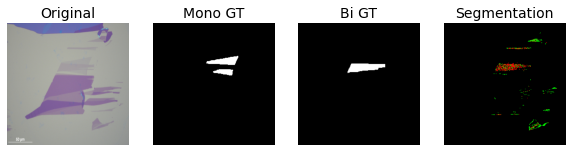

1/1 [==============================] - 0s 26ms/step


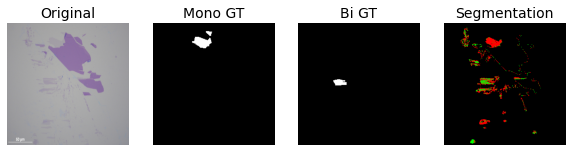

1/1 [==============================] - 0s 39ms/step


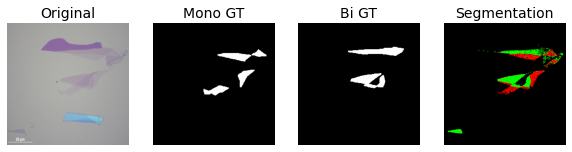

1/1 [==============================] - 0s 37ms/step


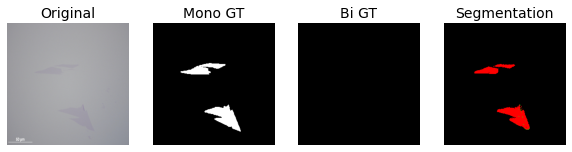

1/1 [==============================] - 0s 26ms/step


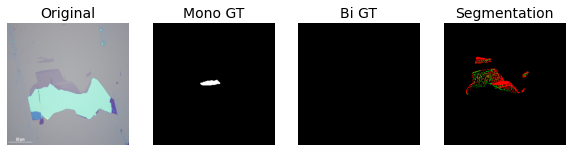

1/1 [==============================] - 0s 33ms/step


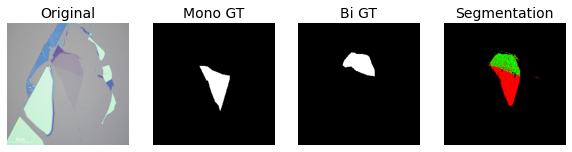

1/1 [==============================] - 0s 29ms/step


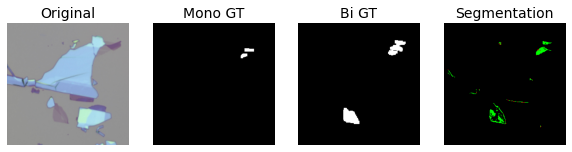

1/1 [==============================] - 0s 25ms/step


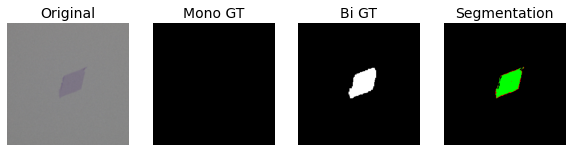

1/1 [==============================] - 0s 25ms/step


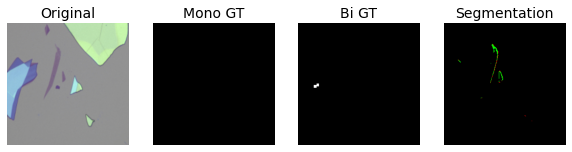

1/1 [==============================] - 0s 24ms/step


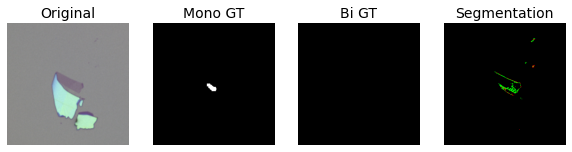

1/1 [==============================] - 0s 29ms/step


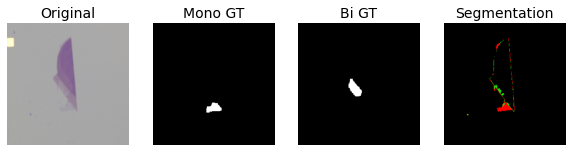

1/1 [==============================] - 0s 34ms/step


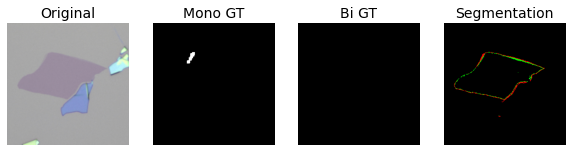

1/1 [==============================] - 0s 27ms/step


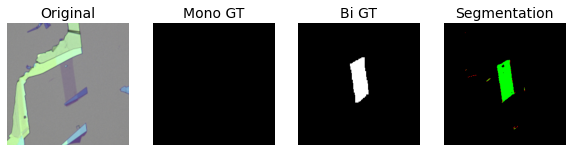

1/1 [==============================] - 0s 40ms/step


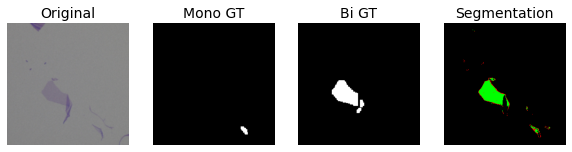

1/1 [==============================] - 0s 36ms/step


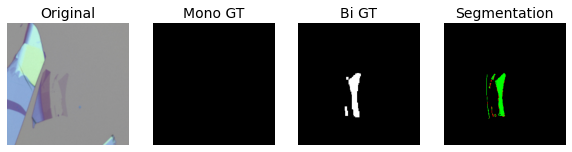

1/1 [==============================] - 0s 33ms/step


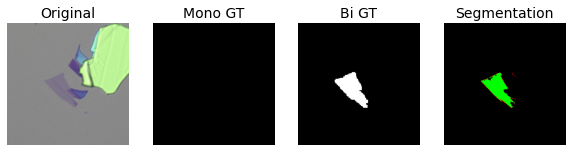

1/1 [==============================] - 0s 44ms/step


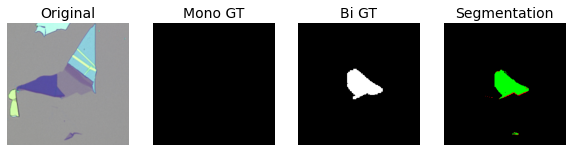

1/1 [==============================] - 0s 79ms/step


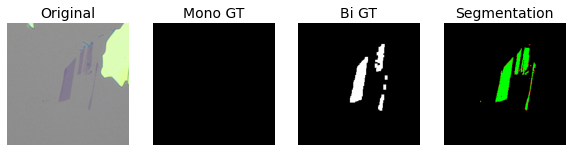

1/1 [==============================] - 0s 30ms/step


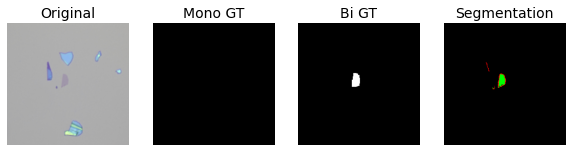

1/1 [==============================] - 0s 25ms/step


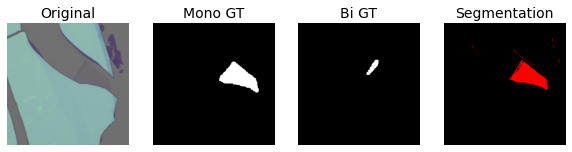

1/1 [==============================] - 0s 27ms/step


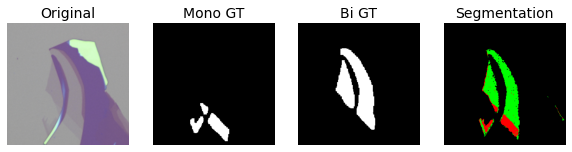

1/1 [==============================] - 0s 27ms/step


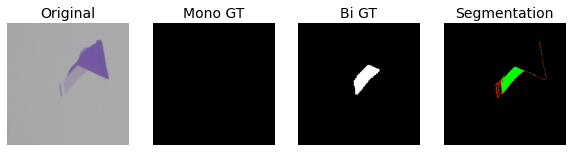

1/1 [==============================] - 0s 26ms/step


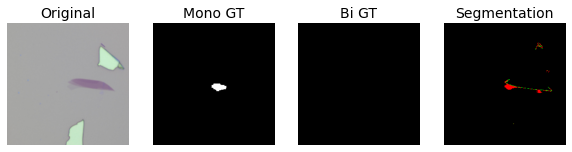

1/1 [==============================] - 0s 40ms/step


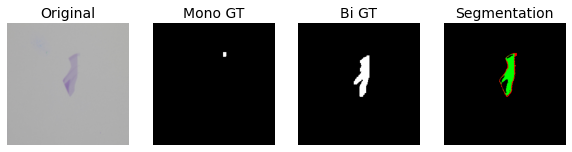

1/1 [==============================] - 0s 36ms/step


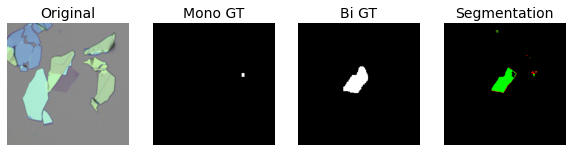

1/1 [==============================] - 0s 29ms/step


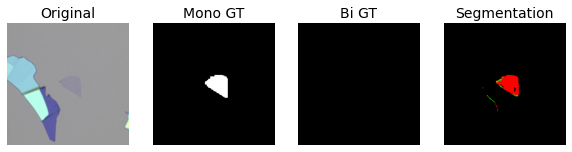

1/1 [==============================] - 0s 28ms/step


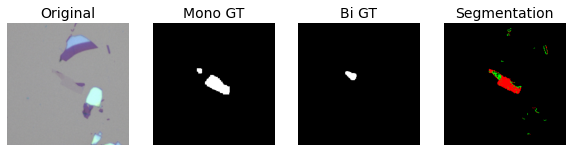

1/1 [==============================] - 0s 41ms/step


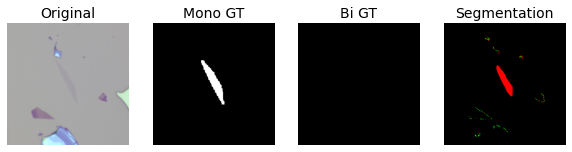

1/1 [==============================] - 0s 27ms/step


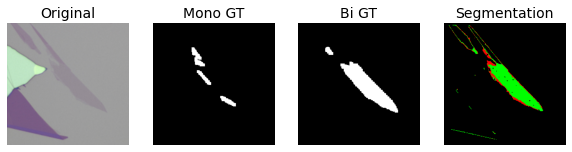

1/1 [==============================] - 0s 28ms/step


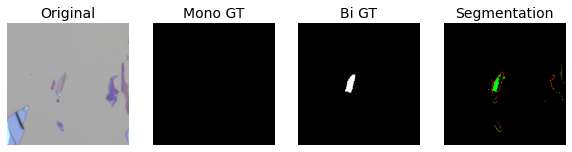

1/1 [==============================] - 0s 25ms/step


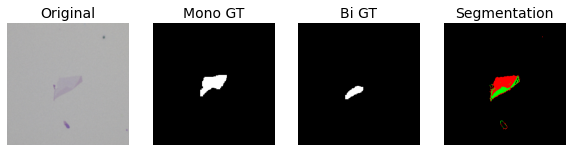

1/1 [==============================] - 0s 34ms/step


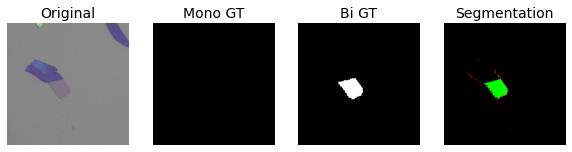

1/1 [==============================] - 0s 29ms/step


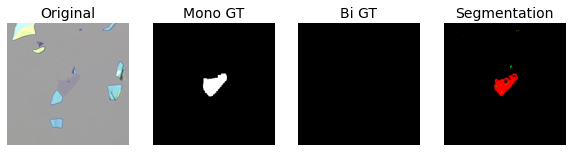

1/1 [==============================] - 0s 24ms/step


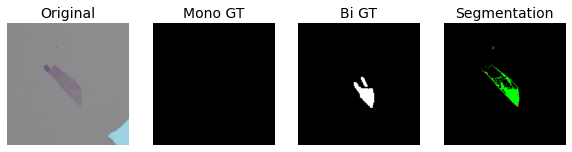

1/1 [==============================] - 0s 36ms/step


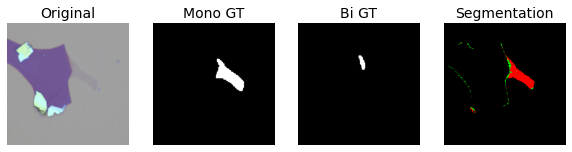

1/1 [==============================] - 0s 32ms/step


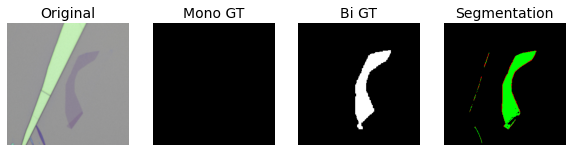

1/1 [==============================] - 0s 35ms/step


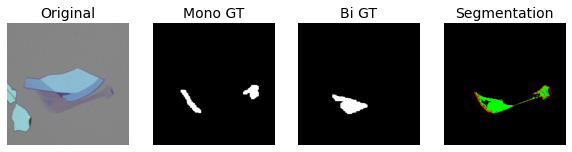

1/1 [==============================] - 0s 39ms/step


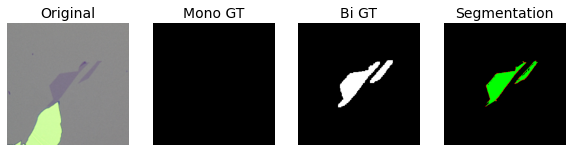

1/1 [==============================] - 0s 23ms/step


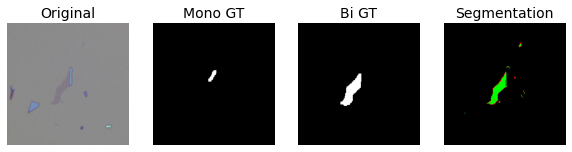

1/1 [==============================] - 0s 24ms/step


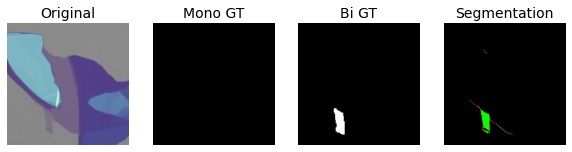

1/1 [==============================] - 0s 23ms/step


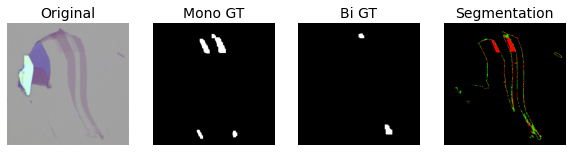

1/1 [==============================] - 0s 29ms/step


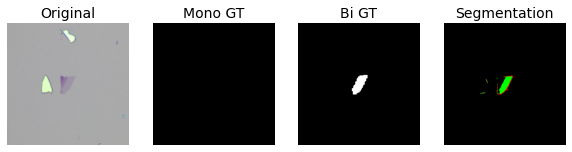

1/1 [==============================] - 0s 39ms/step


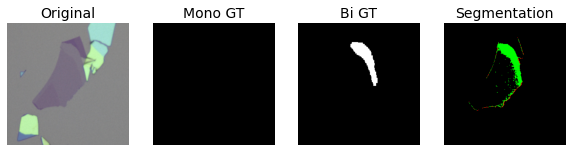

1/1 [==============================] - 0s 29ms/step


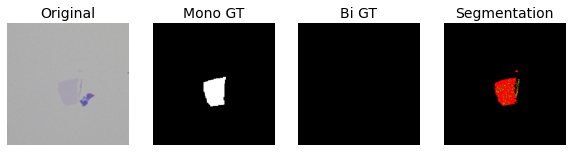

1/1 [==============================] - 0s 27ms/step


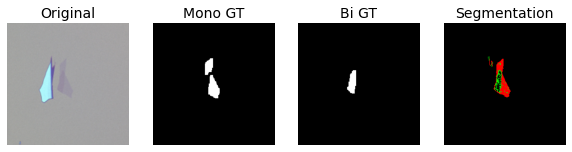

1/1 [==============================] - 0s 40ms/step


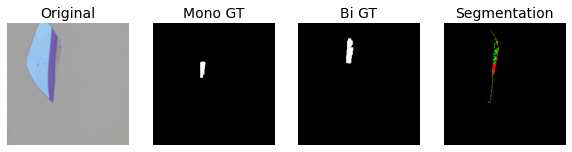

1/1 [==============================] - 0s 45ms/step


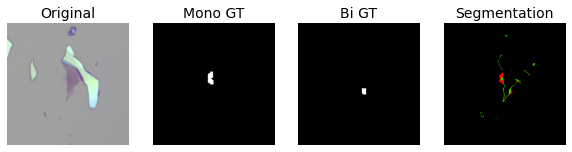

1/1 [==============================] - 0s 44ms/step


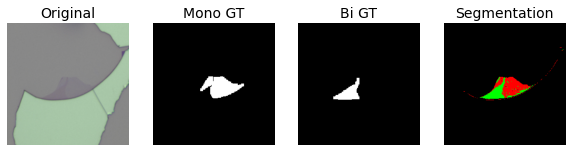

1/1 [==============================] - 0s 30ms/step


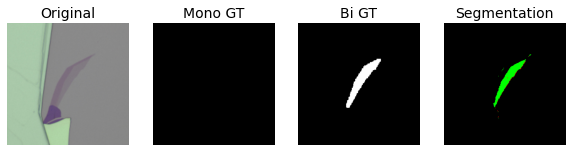

1/1 [==============================] - 0s 27ms/step


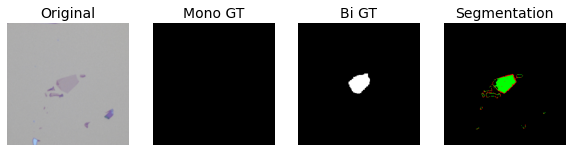

1/1 [==============================] - 0s 27ms/step


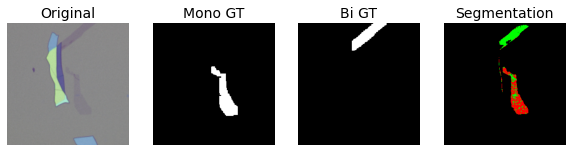

1/1 [==============================] - 0s 25ms/step


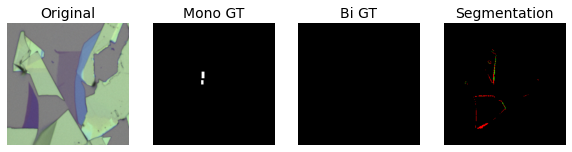

1/1 [==============================] - 0s 26ms/step


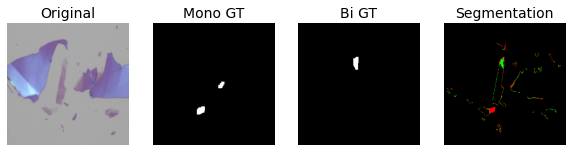

1/1 [==============================] - 0s 24ms/step


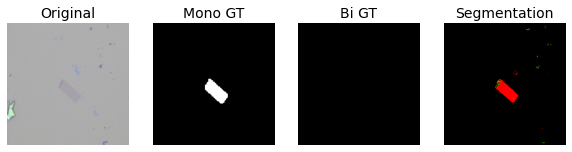

1/1 [==============================] - 0s 53ms/step


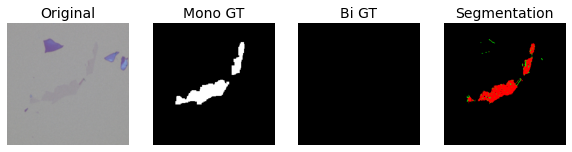

1/1 [==============================] - 0s 47ms/step


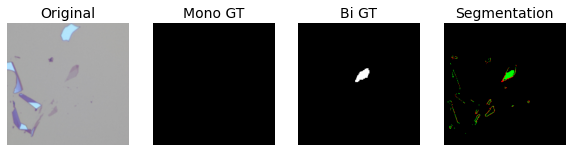

In [48]:
log_segmentation_pics(dataset_train)

The end.